In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os

from IPython import display

Movie dataset from: http://www.cs.cornell.edu/people/pabo/movie-review-data/

In [ ]:
path = "rt-polaritydata/rt-polaritydata/"

pos_path = os.path.join(path, 'rt-polarity.pos')
neg_path = os.path.join(path, 'rt-polarity.neg')
print(pos_path, neg_path)

In [ ]:
def load_review(path, is_pos=True):
    with open(path) as f:
        review = pd.DataFrame({'review':f.read().splitlines()})
    review['sentiment'] = 1 if is_pos else 0
    return review

In [ ]:
pos_review = load_review(pos_path, is_pos=True)
neg_review = load_review(neg_path, is_pos=False)

display.display(pos_review.head(), neg_review.head())

In [ ]:
all_reviews = pd.concat([pos_review, neg_review])
all_reviews.head()

Basic/Toy model

In [6]:
import operator
from functools import reduce

def create_vocabulary(df):
    splitted_reviews = df.review.map(lambda line: line.split())
    vocab = set(reduce(operator.add, splitted_reviews))
    return list(vocab)

In [7]:
vocab = create_vocabluary(all_reviews)

VOCAB_SIZE = len(vocab)
print('Total vocabluary size: {} words'.format(VOCAB_SIZE))

Total vocabluary size: 21425 words


In [8]:
lookup_vocab_table = {vocab[i]: i for i in range(VOCAB_SIZE)}

In [9]:
df = all_reviews.copy()

In [10]:
df["review_splitted"] = df.review.map(lambda line: line.split())
df.head()

,review,sentiment,review_splitted
0,the rock is destined to be the 21st century's ...,1,"[the, rock, is, destined, to, be, the, 21st, c..."
1,"the gorgeously elaborate continuation of "" the...",1,"[the, gorgeously, elaborate, continuation, of,..."
2,effective but too-tepid biopic,1,"[effective, but, too-tepid, biopic]"
3,if you sometimes like to go to the movies to h...,1,"[if, you, sometimes, like, to, go, to, the, mo..."
4,"emerges as something rare , an issue movie tha...",1,"[emerges, as, something, rare, ,, an, issue, m..."


In [159]:
def review_to_one_hot(row):
    one_hot = [0 for i in range(VOCAB_SIZE)]
    for i, word in enumerate(lookup_vocab_table):
        if word in row:
            one_hot[i] = 1
    return one_hot

In [160]:
t = df.review_splitted.apply(lambda row: review_to_one_hot(row))

In [191]:
one_hot_df = pd.DataFrame(t.array, columns = lookup_vocab_table.keys())

Build simple Naive Bayes classificator

In [196]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 4

X = one_hot_df
y = df.sentiment.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape

((9595, 21425), (1067, 21425), (9595,))

In [197]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

accuracy = (y_test != y_pred).sum() / X_test.shape[0]
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.3345829428303655


In [198]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
y_pred = rf.fit(X_train, y_train).predict(X_test)

accuracy = (y_test != y_pred).sum() / X_test.shape[0]
print('Accuracy: {}'.format(accuracy))

C:\Users\studia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.3626991565135895


In [226]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(VOCAB_SIZE,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-2), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [227]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1024)              21940224  
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)              

In [228]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                           patience=5)

history = model.fit(X_train, 
                    y_train, 
                    epochs=20,
                    validation_data=(X_test, y_test),
                    batch_size=64,
                    callbacks=[early_stopping_callback])

Train on 9595 samples, validate on 1067 samples
Epoch 1/20
9595/9595 [==============================] - 12s 1ms/sample - loss: 0.6360 - accuracy: 0.6576 - val_loss: 0.5226 - val_accuracy: 0.7460
Epoch 2/20
9595/9595 [==============================] - 11s 1ms/sample - loss: 0.4167 - accuracy: 0.8382 - val_loss: 0.5426 - val_accuracy: 0.7657
Epoch 3/20
9595/9595 [==============================] - 12s 1ms/sample - loss: 0.2895 - accuracy: 0.9062 - val_loss: 0.7157 - val_accuracy: 0.7385
Epoch 4/20
9595/9595 [==============================] - 12s 1ms/sample - loss: 0.2269 - accuracy: 0.9343 - val_loss: 0.8460 - val_accuracy: 0.7291
Epoch 5/20
9595/9595 [==============================] - 12s 1ms/sample - loss: 0.1842 - accuracy: 0.9496 - val_loss: 1.3702 - val_accuracy: 0.7310
Epoch 6/20
9595/9595 [==============================] - 12s 1ms/sample - loss: 0.2092 - accuracy: 0.9422 - val_loss: 1.1980 - val_accuracy: 0.7657
Epoch 7/20
9595/9595 [==============================] - 12s 1ms/sample

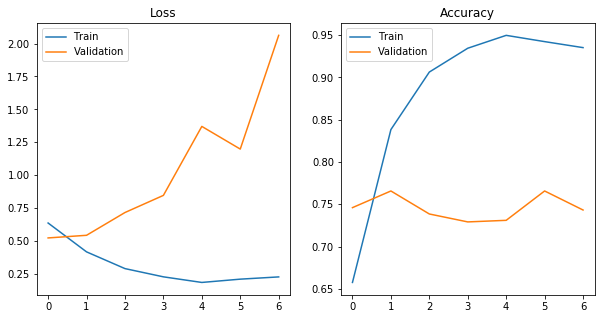

In [229]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.show()

In [230]:
model.save_weights('base_model')